# RL and Advanced DL. Homework #1
<br>

Task text:
<br>

https://docs.google.com/document/d/1u-JiK2opyDeZ2h21nnnmuumyRyYlUL5K3Id7QTWihOU/
<br>

In [57]:
import gym
from gym import spaces
from gym.envs.toy_text.blackjack import BlackjackEnv

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

# I. Basic Blackjack environment in Gym 

Let us start with exploration of environment for Blackjack.

In [30]:
env = BlackjackEnv()

print(env.observation_space)
print(env.action_space)

The state/observation is represented as a tuple of:
- sum of player's card scores
- score of one opened dealer's card
- flag of usable ace (whether ace costs 1 or 11 pts)

<br>

Possible actions of player:
- hit (1) - take extra card to his/her hand
- stick/stand (0) - finish with own cards and let dealer play out

## 1. Simple policy

Now we evaluate simple policy: player takes a **hit** when sum of scores equals 19, 20, or 21. In all other cases player chooses to **stand**.

*Note* Everywhere after in code I use following notation:
- s - current state
- a - current action
- r - reward
- s_ - next state
- a_ - next action

In [66]:
MAX_PLAYER_SUM = 32


def simple_policy():
    pi = np.zeros(MAX_PLAYER_SUM)
    pi[19:21+1] = 1
    return pi.astype(int)

def MC_estimation(env, n_episodes, verbose=False, eps=1e-9):
    sum_reward = 0
    sum_reward_by_state = np.zeros(MAX_PLAYER_SUM)
    n_episodes_with_state = np.zeros(MAX_PLAYER_SUM)
    mean_rewards = []
    pi = simple_policy()
    for cur_episode in tqdm(range(n_episodes), disable=not verbose):
        s = env.reset()
        s = s[0]
        states_in_episode = [s]
        finished = False
        while not finished:
            s, r, finished, _ = env.step(pi[s])
            s = s[0]
            states_in_episode.append(s)
        states_in_episode = list(set(states_in_episode))
        n_episodes_with_state[states_in_episode] += 1
        sum_reward_by_state[states_in_episode] += r
        sum_reward += r
        mean_rewards.append(sum_reward / (cur_episode + 1))
    
    value_function = sum_reward_by_state / (n_episodes_with_state + eps)
    return value_function, mean_rewards

In [67]:
%%time
value_function, mean_rewards = MC_estimation(env, n_episodes=10000, verbose=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 748 ms, sys: 0 ns, total: 748 ms
Wall time: 774 ms


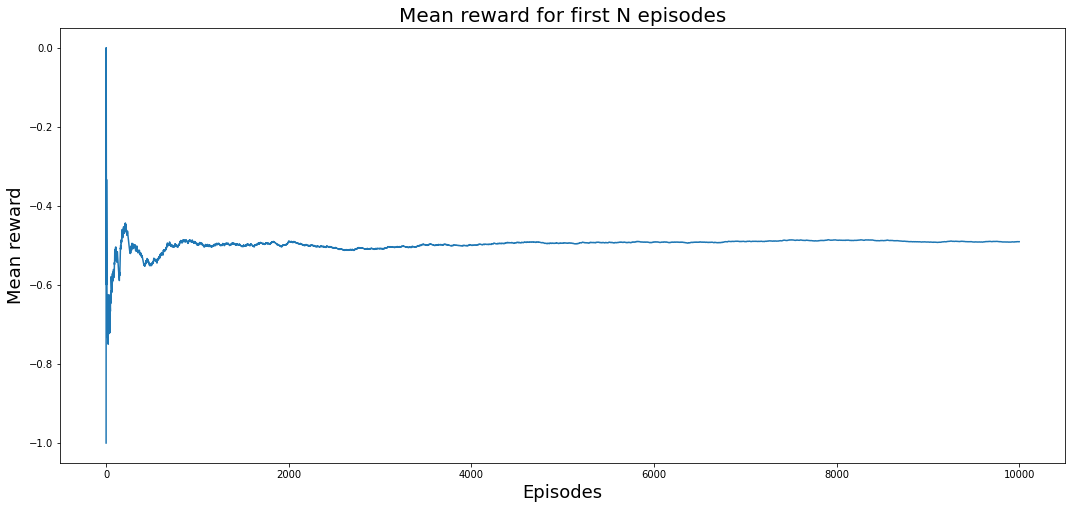

In [73]:
plt.figure(figsize=(18,8))
plt.title("Mean reward for first N episodes", fontsize=20)
plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Mean reward", fontsize=18)
plt.plot(mean_rewards);

Monte-Carlo method provided an estimation for mean reward, the result for such simple policy is pretty low.

Now we try to learn algorithms.

## 2. Learning

I use Reinforcement Learning methods to obtain better strategy in this task. We will try Monte-Carlo control and Q-learning.

In [158]:
# observation is a tuple (player_sum, dealer_card, usable_ace)

MAX_CARD_SCORE = 11
N_ACTIONS = 2


def init_Q(val=None):
    Q = {}
    for player_sum in range(MAX_PLAYER_SUM):
        for dealer_card in range(MAX_CARD_SCORE):
            for usable_ace in range(2):
                Q[(player_sum, dealer_card, usable_ace)] = np.random.randn(N_ACTIONS) if val is None else val * np.ones(N_ACTIONS)
    return Q


def compute_policy_by_Q(Q):
    pi = {}
    for s in Q:
        pi[s] = np.argmax(Q[s])
    return pi


def Q_learning_episode(env, pi, Q, alpha=0.05, temperature=0.0, gamma=0.9):
    s = env.reset()
    a = pi[s] if np.random.rand() > temperature else np.random.randint(N_ACTIONS)
    finished = False
    while not finished:
        s_, r, finished, _ = env.step(a)
        a_ = pi[s_] if np.random.rand() > temperature else np.random.randint(N_ACTIONS)
        Q[s][a] = Q[s][a] + alpha * (r + gamma * np.max(Q[s_]) - Q[s][a])
        s, a = s_, a_
    return Q, r

def Q_learning(env, n_episodes, alpha=0.1, temperature=0.0, gamma=0.95, verbose=False):
    sum_reward = 0
    mean_rewards = []
    Q = init_Q()
    pi = compute_policy_by_Q(Q)
    for cur_episode in tqdm(range(n_episodes), disable=not verbose):
        Q, r = Q_learning_episode(env, pi, Q, alpha=alpha, temperature=temperature, gamma=gamma)
        pi = compute_policy_by_Q(Q)
        sum_reward += r
        mean_rewards.append(sum_reward / (cur_episode + 1))
    return pi, Q, mean_rewards


def run_episode(env, pi, temperature=0.0):
    s = env.reset()
    a = pi[s] if np.random.rand() > temperature else np.random.randint(N_ACTIONS)
    finished = False
    states, actions = [s], [a]
    while not finished:
        s, r, finished, _ = env.step(a)
        a = pi[s] if np.random.rand() > temperature else np.random.randint(N_ACTIONS)
        states.append(s)
        actions.append(a)
    return states, actions, r

def MC_control(env, n_episodes, gamma=0.95, temperature=0.0, eps=1e-9, verbose=False):
    sum_reward = 0
    mean_rewards = []
    sum_rewards_by_sa = init_Q(0)
    n_episodes_with_sa = init_Q(eps)
    for cur_episode in tqdm(range(n_episodes), disable=not verbose):
        Q = init_Q()
        pi = compute_policy_by_Q(Q)
        states, actions, r = run_episode(env, pi, temperature=temperature)
        sum_reward += r
        mean_rewards.append(sum_reward / (cur_episode + 1))
        for s, a in zip(states[:-1], actions):
            sum_rewards_by_sa[s][a] += r
            n_episodes_with_sa[s][a] += 1
    Q = init_Q(0)
    for s, a in zip(states[:-1], actions):
        Q[s][a] = sum_rewards_by_sa[s][a] / n_episodes_with_sa[s][a]
    pi = compute_policy_by_Q(Q)
    return pi, Q, mean_rewards

In [171]:
def plot_alg(array, alg_name, cut_first=10):
    plt.figure(figsize=(18,8))
    plt.title(f"{alg_name}: Mean reward for first N episodes", fontsize=20)
    plt.xlabel("Episodes", fontsize=18)
    plt.ylabel("Mean reward", fontsize=18)
    plt.plot(array[cut_first:]);

def plot_by_param(reward_arrays, params, param_name, alg_name, cut_first=10):
    plt.figure(figsize=(18,9))
    plt.title(f"{alg_name}: Mean reward for first N episodes", fontsize=20)
    plt.xlabel("Episodes", fontsize=18)
    plt.ylabel("Mean reward", fontsize=18)
    assert len(reward_arrays) == len(params)
    for array, param in zip(reward_arrays, params):
        plt.plot(array[cut_first:], label=f"{param_name} = {param}")
    plt.legend(fontsize=20);

There are few hypermarameters in both methods like:
- $\gamma$ - discount factor for reward
- $\alpha$ - learning rate
- temperature - used for exploration/exploitation tradeoff

In [104]:
pi, Q, mean_rewards = MC_control(env, n_episodes=10000, verbose=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

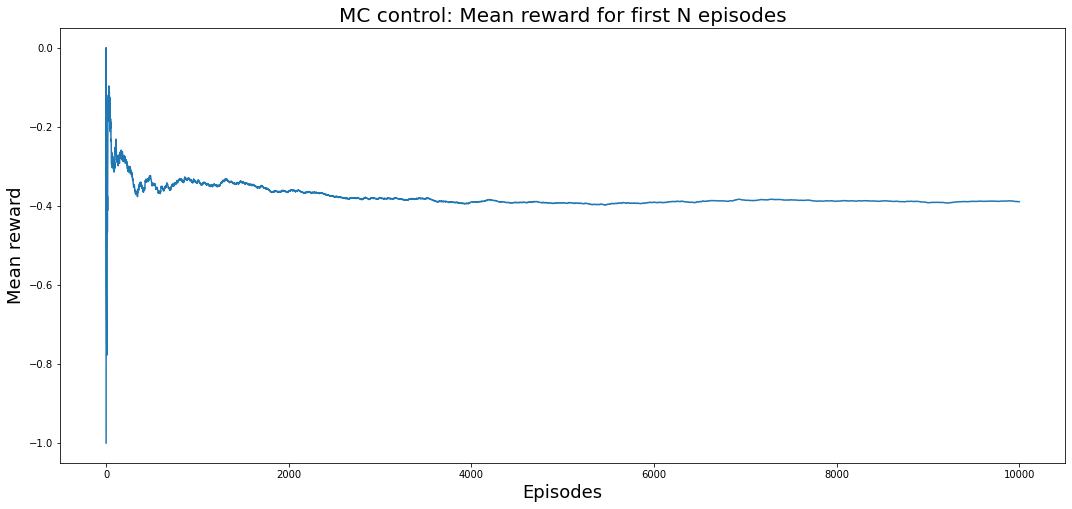

In [105]:
plt.figure(figsize=(18,8))
plt.title("MC control: Mean reward for first N episodes", fontsize=20)
plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Mean reward", fontsize=18)
plt.plot(mean_rewards);

In [130]:
%%time
alpha_1 = [0.3, 0.1, 0.03]
mean_rewards_1 = []
for alpha in alpha_1:
    pi, Q, mean_rewards = Q_learning(env, n_episodes=10000, alpha=alpha, verbose=True)
    mean_rewards_1.append(mean_rewards)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 54.5 s, sys: 1.62 s, total: 56.2 s
Wall time: 55.2 s


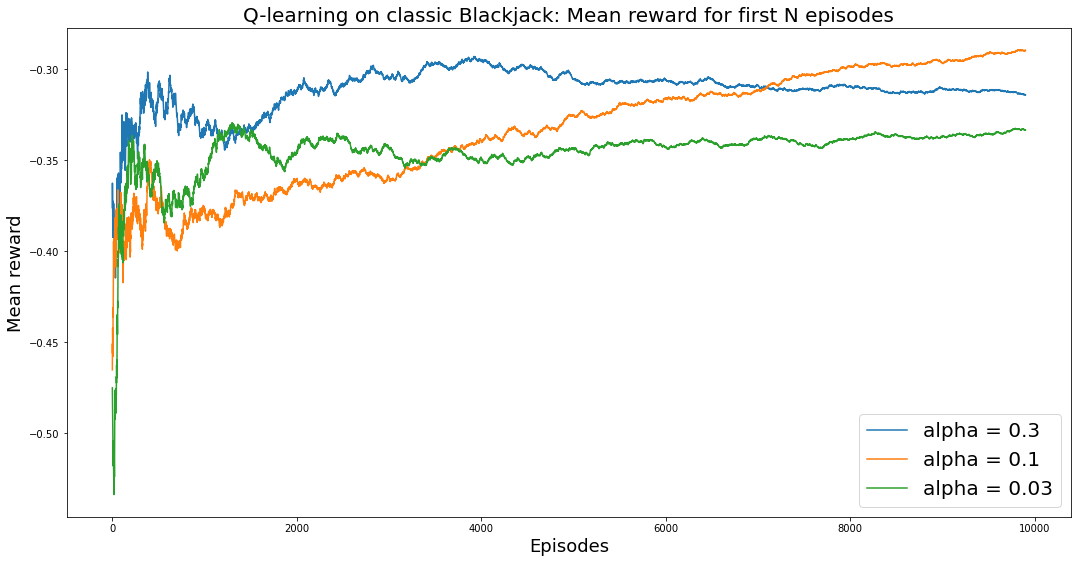

In [139]:
plot_by_param(mean_rewards_1, alpha_1, "alpha", "Q-learning on classic Blackjack", cut_first=100)

Few conclusions:
- learning rate seems to be the most influencial factor for this problem. Reward factor does not count much due to shortness of episodes, same happens to temperature - MC sampling controls this aspect.
- Q-learning learns faster than MC control, therefore we will make more stress on the first method.

# II. Blackjack with "double" option

Here we observe modifcation of classic Blackjack: now the player has an option to **double** his bet, in this case the player gets one extra card, and the dealer plays out.

In [159]:
N_ACTIONS = 3

class DoubleBlackjackEnv(BlackjackEnv):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(N_ACTIONS)

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2:
            obs, reward, done, _ = super().step(1)
            if not done:
                obs, reward, done, _ = super().step(0)
            return self._get_obs(), reward * 2, done, {}
        else:
            return super().step(action)

In [160]:
env2 = DoubleBlackjackEnv()

Let us check correctness of the environment and see few episodes.

In [161]:
def check_environment(env_, n_episodes=15):
    print("STATES | ACTIONS | REWARD\n-------------------------")
    for _ in range(n_episodes):
        s = env_.reset()
        states = [s]
        actions = []
        while True:
            a = memenv.action_space.sample()
            s, r, done, _ = env_.step(a)
            states.append(s)
            actions.append(a)
            if done:
                break
        print(states, actions, r)

In [162]:
check_environment(env2)

STATES | ACTIONS | REWARD
-------------------------
[(17, 10, False), (17, 10, False)] [0] -1.0
[(7, 10, False), (15, 10, False), (22, 10, False)] [1, 2] -2.0
[(13, 10, True), (13, 10, False), (23, 10, False)] [1, 1] -1.0
[(20, 5, False), (20, 5, False)] [0] 1.0
[(13, 9, False), (15, 9, False)] [2] 2.0
[(8, 9, False), (11, 9, False)] [2] -2.0
[(14, 1, False), (24, 1, False)] [1] -1.0
[(16, 8, True), (20, 8, True)] [2] 2.0
[(16, 5, False), (22, 5, False)] [2] -2.0
[(20, 6, False), (27, 6, False)] [2] -2.0
[(18, 4, False), (18, 4, False)] [0] 1.0
[(15, 10, False), (15, 10, False)] [0] -1.0
[(16, 9, False), (26, 9, False)] [1] -1.0
[(16, 9, False), (26, 9, False)] [1] -1.0
[(12, 1, False), (22, 1, False)] [1] -1.0


Everything is OK. Now let us come to learning.

In [167]:
%%time
pi, Q, mean_rewards_2_mc = MC_control(env2, n_episodes=100000, verbose=True)

  0%|          | 0/100000 [00:00<?, ?it/s]

CPU times: user 5min 3s, sys: 2.94 s, total: 5min 5s
Wall time: 5min 5s


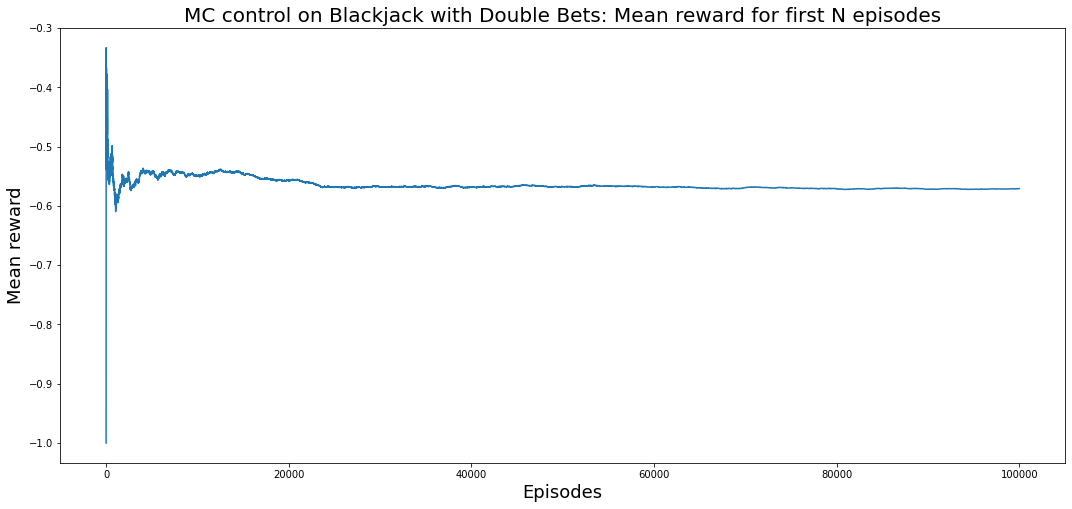

In [173]:
plot_alg(mean_rewards_2_mc, "MC control on Blackjack with Double Bets", cut_first=10)

In [174]:
%%time
alpha_array = [0.3, 0.1, 0.03]
mean_rewards_2 = []
for alpha in alpha_array:
    pi, Q, mean_rewards = Q_learning(env2, n_episodes=150000, alpha=alpha, verbose=True)
    mean_rewards_2.append(mean_rewards)

  0%|          | 0/150000 [00:00<?, ?it/s]

  0%|          | 0/150000 [00:00<?, ?it/s]

  0%|          | 0/150000 [00:00<?, ?it/s]

CPU times: user 13min 24s, sys: 13.2 s, total: 13min 37s
Wall time: 13min 30s


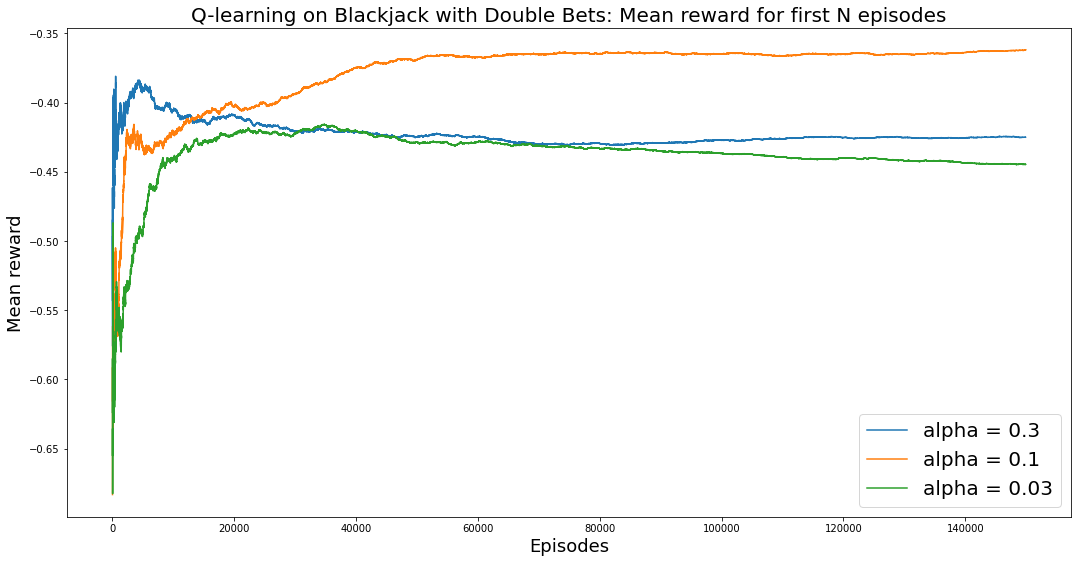

In [175]:
plot_by_param(mean_rewards_2, alpha_array, "alpha", "Q-learning on Blackjack with Double Bets", cut_first=100)

# III. Blackjack with improved memory of player

Another improvement: now the player has ability to keep in mind the story of previous episodes. The dealer plays same card deck without replacement until the amount of cards in the deck runs out or becomes low (15 cards in our case).

We should understand that the dimension of state space is very huge even on previous steps, and we need to save useful information on the game in compact form like **total sum** or **total average** amount of card which were used in the game up to current moment, before the deck is shuffled.

Let us develop class *MemoryBlackjackEnv* for Blackjack environment with memory.

In [176]:
class MemoryBlackjackEnv(BlackjackEnv):
    def __init__(self, min_deck_size=15):
        self._full_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.deck = self._full_deck.copy()
        self.min_deck_size = min_deck_size
        super().__init__()
        self.sab = False
        self.action_space = spaces.Discrete(3)
        # player_sum, dealer_card, n_cards_in_game, mean_nominal
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32), 
            spaces.Discrete(11), 
            spaces.Discrete(len(self._full_deck) - self.min_deck_size), 
            spaces.Discrete(11),
        ))

    def _draw_card(self):
        if len(self.deck) <= self.min_deck_size:
            self.deck = self._full_deck.copy()
        ix = np.random.choice(range(len(self.deck)))
        return self.deck.pop(ix)

    def _draw_hand(self):
        if len(self.deck) <= self.min_deck_size + 1:
            self.deck = self._full_deck.copy()
        return [self._draw_card(), self._draw_card()]

    def _score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self._is_bust(hand) else self._sum_hand(hand)

    def _is_bust(self, hand):  # Is this hand a bust?
        return self._sum_hand(hand) > 21

    def _sum_hand(self, hand):  # Return current hand total
        if self._usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)

    @staticmethod
    def _usable_ace(hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21
    
    @staticmethod
    def _is_natural(hand):  # Is this hand a natural blackjack?
        return sorted(hand) == [1, 10]

    @staticmethod
    def _cmp(a, b):
        return float(a > b) - float(a < b)

    def _play_hit(self):
        self.player.append(self._draw_card())
        if self._is_bust(self.player):
            done = True
            reward = -1.0
        else:
            done = False
            reward = 0.0
        return reward, done

    def _play_stick(self):
        done = True
        while self._sum_hand(self.dealer) < 17:
            self.dealer.append(self._draw_card())
        reward = self._cmp(self._score(self.player), self._score(self.dealer))
        if self.sab and self._is_natural(self.player) and not self._is_natural(self.dealer):
            # Player automatically wins. Rules consistent with S&B
            reward = 1.0
        elif (
            not self.sab
            and self.natural
            and self._is_natural(self.player)
            and reward == 1.0
        ):
            # Natural gives extra points, but doesn't autowin. Legacy implementation
            reward = 1.5
        return reward, done

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 0:  
            # stick: play out the dealers hand, and score
            reward, done = self._play_stick()
        elif action == 1:  
            # hit: add a card to players hand and return
            reward, done = self._play_hit()
        else:
            # double: add a card, double reward and return
            reward, done = self._play_hit()
            if not done:
                reward, done = self._play_stick()
            reward *= 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        n_cards_in_game = len(self._full_deck) - len(self.deck)
        mean_nominal_in_game = int(np.round((sum(self._full_deck) - sum(self.deck)) / n_cards_in_game))
        return (
            self._sum_hand(self.player), 
            self.dealer[0], 
            mean_nominal_in_game,
            # n_cards_in_game,
        )

    def reset(self):
        self.dealer = self._draw_hand()
        self.player = self._draw_hand()
        return self._get_obs()

Here the state is represented as tuple
- sum of player's card scores
- score of one opened dealer's card
- *mean nominal/score of cards in game*

Optionally we may also use *number of cards in game*, but the dimension would be extremely huge.

We start with correctness check.

In [177]:
memenv = MemoryBlackjackEnv() 

In [178]:
check_environment(memenv)

STATES | ACTIONS | REWARD
-------------------------
[(14, 10, 8), (21, 10, 7), (31, 10, 8)] [1, 2] -2.0
[(8, 4, 7), (8, 4, 7)] [0] -1.0
[(18, 10, 7), (18, 10, 7)] [0] 1.0
[(13, 6, 7), (13, 6, 7)] [0] -1.0
[(17, 10, 7), (17, 10, 7), (27, 10, 7)] [1, 2] -2.0
[(9, 10, 7), (17, 10, 7), (17, 10, 7)] [1, 0] -1.0
[(20, 5, 10), (20, 5, 10)] [0] 1.0
[(13, 5, 7), (13, 5, 7)] [0] -1.0
[(20, 7, 8), (28, 7, 8)] [1] -1.0
[(21, 4, 7), (15, 4, 7), (15, 4, 7)] [1, 0] 1.0
[(19, 8, 7), (20, 8, 7), (20, 8, 7)] [1, 0] 1.0
[(13, 7, 7), (22, 7, 7)] [1] -1.0
[(12, 10, 7), (16, 10, 7)] [2] -2.0
[(15, 10, 8), (25, 10, 8)] [1] -1.0
[(12, 7, 7), (22, 7, 8)] [1] -1.0


Q-function is redefined for this environment.

In [179]:
MAX_CARDS_IN_GAME = 52 - 15 + 1

def init_Q(val=None):
    Q = {}
    for player_sum in range(MAX_PLAYER_SUM):
        for dealer_card in range(MAX_CARD_SCORE):
            for mean_nominal_in_game in range(MAX_CARD_SCORE):
                Q[(player_sum, dealer_card, mean_nominal_in_game)] = np.random.randn(N_ACTIONS) if val is None else val * np.ones(N_ACTIONS)
                # for n_cards_in_game in range(MAX_CARDS_IN_GAME):
                #     Q[(player_sum, dealer_card, mean_nominal_in_game, n_cards_in_game)] = np.random.randn(N_ACTIONS) if val is None else val * np.ones(N_ACTIONS)
    return Q

In [180]:
%%time
alpha_array = [0.3, 0.1, 0.03]
mean_rewards_mem = []
for alpha in alpha_array:
    pi, Q, mean_rewards = Q_learning(memenv, n_episodes=100000, alpha=alpha, verbose=True)
    mean_rewards_mem.append(mean_rewards)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

CPU times: user 48min 37s, sys: 46.5 s, total: 49min 24s
Wall time: 49min 1s


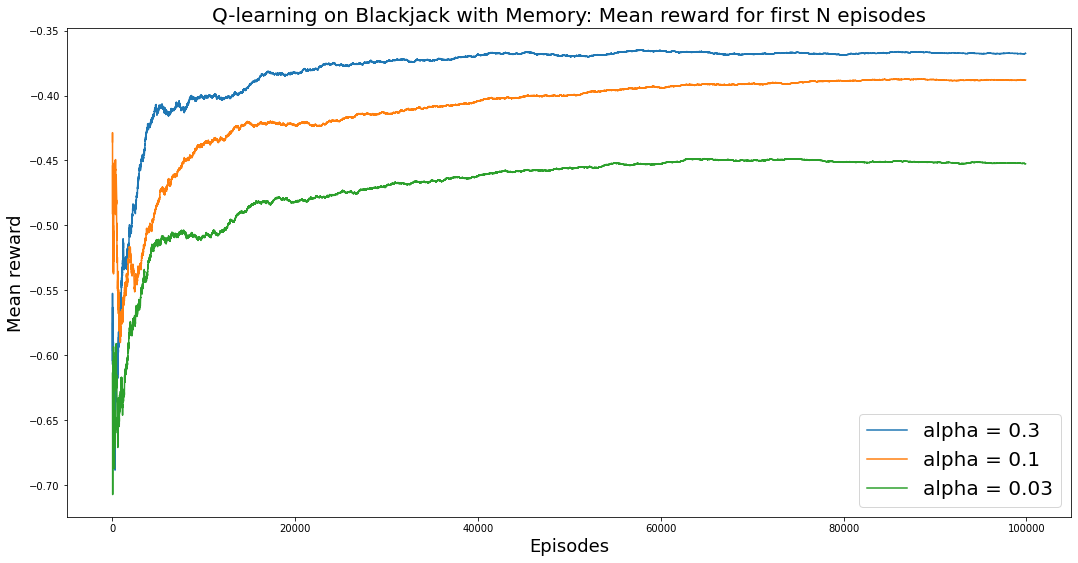

In [181]:
plot_by_param(mean_rewards_mem, alpha_array, "alpha", "Q-learning on Blackjack with Memory", cut_first=100)